# Compare Gaia data products for internal consistency in energy

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
import re as regex
getobmt = lambda path: int(regex.search("(?<=OBMT_START_)[0-9]+",path).group(0))
import os

In [3]:
from astropy.io import fits

def fits_energies(filename):
    """
    Extract deposited energies from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and a list of energy lists [eV] - one list per acqTime
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create array for OBMT
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    # Empty list for energies
    energies = []
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        # write acquisition time
        acqTimes[ii-1] = head["ACQTIME"]
        
        energies.append(list(hdulist[ii].data["TRACK_EN"]))
    
    # Close the file
    hdulist.close()
    
    return acqTimes, energies

In [4]:
# for some reason, this really distorts my energies (even somehow increasing some histogram columns???)
# I need to find out why!

def fits_energies_edgeless(filename):
    """
    Extract deposited energies from a fits file of TrackObs
    Returns an array of acqTimes [OBMT] and a list of energy lists [eV] - one list per acqTime
    EXCLUDE all cosmics that are on the edge of the image!
    """
    # Open the file
    hdulist = fits.open(filename)
    
    # Create array for OBMT
    acqTimes = np.empty(len(hdulist)-1, dtype=float)
    # Empty list for energies
    energies = []
    rejected = []
    
    # Iterate over all the track-observations
    for ii in range(1,len(hdulist),1):
        head = hdulist[ii].header        
        
        # write acquisition time
        acqTimes[ii-1] = head["ACQTIME"]
        
        # get size of the image
        al_max = head["SRC_AL"]
        ac_max = head["SRC_AC"]
        
        # get the edges of all the cosmics
        beg_al = hdulist[ii].data["LOC_AL"]
        beg_ac = hdulist[ii].data["LOC_AC"]
        end_al = beg_al + hdulist[ii].data["DIM_AL"]
        end_ac = beg_ac + hdulist[ii].data["DIM_AC"]
        
        edgecosmics = np.logical_or(np.logical_or(beg_al == 0, end_al == al_max), 
                                    np.logical_or(beg_ac == 0, end_ac == ac_max))
        
        energies.append(hdulist[ii].data["TRACK_EN"])
        rejected.append(edgecosmics)
    
    # Close the file
    hdulist.close()
    
    return acqTimes, energies, rejected

In [5]:
def concatenate_energies(e_in, indices):
    """
    Turn the entries of e_in at indices into a flat list
    """
    e_out = []
    for ii in indices:
        e_out += list(e_in[ii])
    return e_out

def concatenate_reject_energies(e_in, rej, indices):
    """
    Turn the entries of e_in at indices into a flat list, rejecting the ones we don't want
    """
    e_out = []
    for ii in indices:
        e_out += list((e_in[ii])[(np.logical_not(rej[ii]))])
    return e_out

# Within BAM-SIF

In [6]:
# BAM-SIF

## BAM-SIF
tbams1 = []
ebams1 = []
rbams1 = []
prefix = "../bam_sif/output/"
for file in os.listdir(prefix):
    if "SIF1" in file:
        t,e,r = fits_energies_edgeless(prefix+file)
        tbams1+= list(t)
        ebams1+= list(e)  
        rbams1+= list(r)
tbams1 = np.array(tbams1)

## BAM-SIF
tbams2 = []
ebams2 = []
rbams2 = []
prefix = "../bam_sif/output/"
for file in os.listdir(prefix):
    if "SIF2" in file:
        t,e,r = fits_energies_edgeless(prefix+file)
        tbams2+= list(t)
        ebams2+= list(e)
        rbams2+= list(r)
tbams2 = np.array(tbams2)

nobs = len(tbams1)

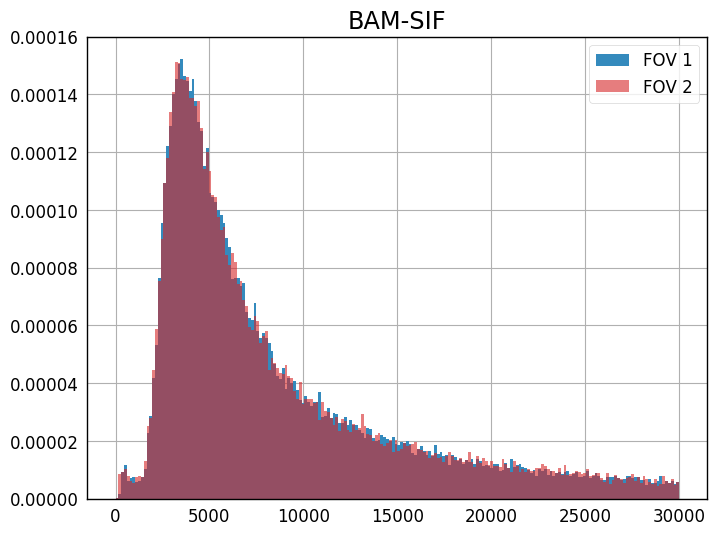

In [7]:
test = plt.hist(concatenate_reject_energies(ebams1,rbams1, range(0,nobs)), 200, range=(0,30000), label="FOV 1", normed=True)
test2 = plt.hist(concatenate_reject_energies(ebams2, rbams2, range(0,nobs)),200, range=(0,30000), label="FOV 2",normed=True,
                 color="tab:red", alpha=0.6)
plt.legend(loc="best")
plt.title("BAM-SIF")

No real difference. That low energy mini-peak is weird.

# Within BAM-OBS

In [17]:
# BAM-OBS

## BAM-SIF
tbam1 = []
ebam1 = []
rbam1 = []
tbam2 = []
ebam2 = []
rbam2 = []

prefix = "../bam/output/2017-07-03_cross_erosion/"
for file in os.listdir(prefix):
    if "OBS1" in file:
        t,e,r = fits_energies_edgeless(prefix+file)
        tbam1+= list(t)
        ebam1+= list(e)  
        rbam1+= list(r)
    elif "OBS2" in file:
        t,e,r = fits_energies_edgeless(prefix+file)
        tbam2+= list(t)
        ebam2+= list(e)
        rbam2+= list(r)
        
tbam1 = np.array(tbam2)
tbam1 = np.array(tbam2)

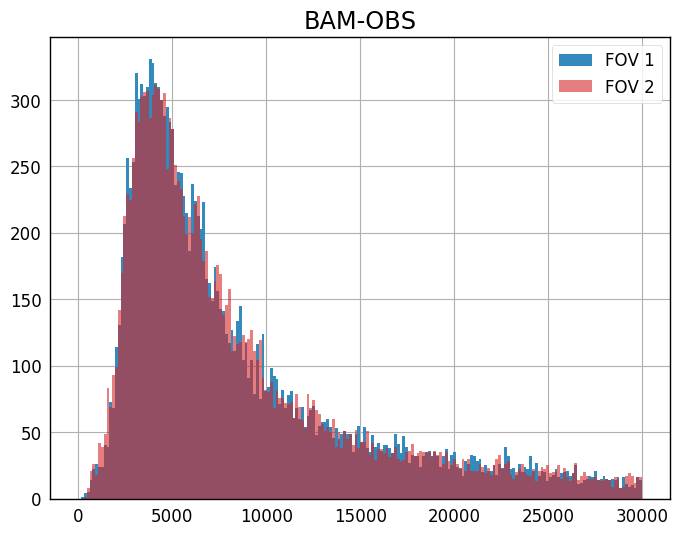

In [32]:
# Note: Not normed
test = plt.hist(concatenate_reject_energies(ebam1,rbam1, range(0,200)), 200, range=(0,30000), normed=False, label="FOV 1")
test2 = plt.hist(concatenate_reject_energies(ebam2,rbam2, range(0,200)),200, range=(0,30000),normed=False, label="FOV 2",
                 color="tab:red", alpha=0.6)

plt.legend(loc="best")
plt.title("BAM-OBS")

# OBS vs SIF

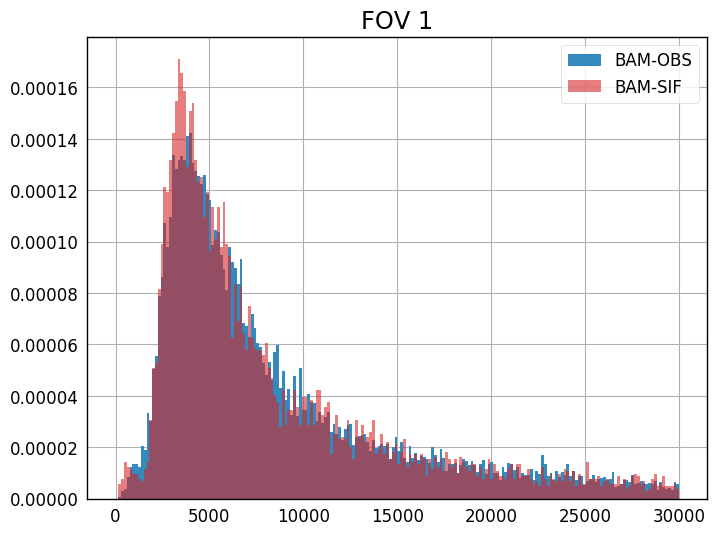

In [19]:
test = plt.hist(concatenate_energies(ebam1, range(0,200)), 200, range=(0,30000), normed=True, label="BAM-OBS")
test2 = plt.hist(concatenate_energies(ebams1, range(0,200)),200, range=(0,30000), normed=True, label="BAM-SIF",
                 color="tab:red", alpha=0.6)

plt.legend(loc="best")
plt.title("FOV 1")

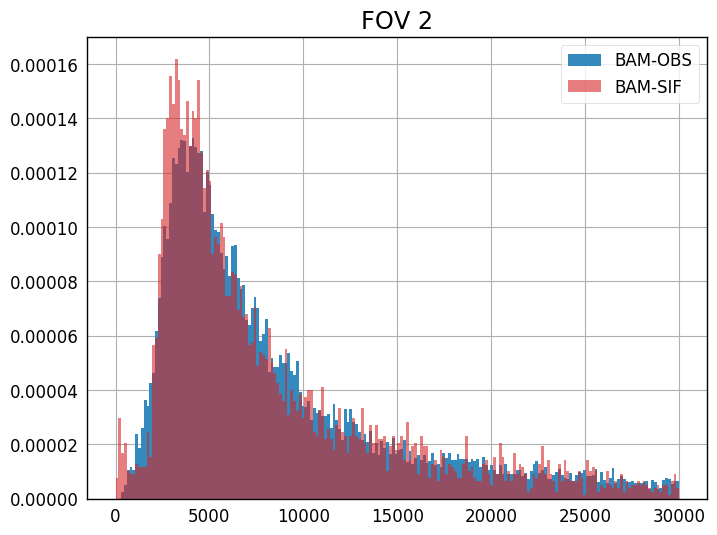

In [20]:
test = plt.hist(concatenate_energies(ebam2, range(0,200)), 200, range=(0,30000), normed=True, label="BAM-OBS")
test2 = plt.hist(concatenate_energies(ebams2, range(0,200)),200, range=(0,30000), normed=True, label="BAM-SIF",
                color="tab:red", alpha=0.6)

plt.legend(loc="best")
plt.title("FOV 2")

# Aside - Reproducing distros

My suspicion is that the "spectral shape" we have is simply a combination of two facts: The total length, which is a function of alpha (giving a 1/sin distro) + the fact that different particles dump different energies.

In [73]:
# a simple test to reproduce my energy distros
E = []
# simulate a few particle species of different flux with different dE/dX
# but, I mean, essentially, that's what TARS does
nparts = [1000,2000,3000,4000,50000,6000,8000,9000,8000,1000]
#nparts = [10000,10000,10000,10000,10000,10000]
dEdX = [4,5,6,7,8,10,9,8,7,6.5] # another way would be to randomly roll the dEdX from some distro
thickness = 1 # of the CCD - does not really matter


for ii in range(len(nparts)):
    angles = np.random.random(nparts[ii])*np.pi/2 # only need from 0 to 90 deg, these are the entrance angles
    pathlen = thickness/np.sin(angles)
    E += list(pathlen*dEdX[ii])

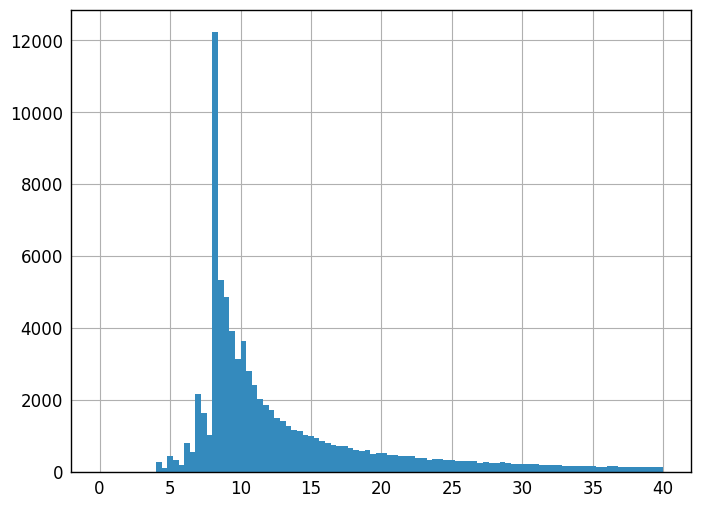

In [74]:
test = plt.hist(E,100, range=(0,40))